In [82]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

from train_dqn import run_dqn_learning

In [83]:
hyper_space_dqn = {'GAMMA': (0.9, 0.99),
                   'L_RATE': (0.0001, 0.05)}

optimizer = BayesianOptimization(f=run_dqn_learning, pbounds=hyper_space_dqn,
                                 verbose=2, random_state=1,)

bo_log_fname = "bo_logs/gridworld_MLP-DQN.json"

# Load in log and define grid on which to evaluate GP

In [84]:
def get_gp_data(bo_log_fname):
    """
    IN: BO log filename, num_hyperparams
    OUT: (X, y) regressors that can then be used to fit the GP surrogate model
    """
    y, X = [], []
    with open(bo_log_fname) as json_file:  
        while True:
            try:
                iteration = next(json_file)
            except StopIteration:
                break
            iteration = json.loads(iteration)
            y.append(iteration["target"])
            X.append(iteration["params"])
    return pd.DataFrame(X), pd.DataFrame({"TARGET": y})


In [85]:
X_obs, y_obs = get_gp_data(bo_log_fname)
f1_list = np.linspace(hyper_space_dqn["GAMMA"][0], hyper_space_dqn["GAMMA"][1], num=50)
f2_list = np.linspace(hyper_space_dqn["L_RATE"][0], hyper_space_dqn["L_RATE"][1], num=50)
f1_grid, f2_grid = np.meshgrid(f1_list, f2_list)
grid = np.vstack([f1_grid.flatten(), f2_grid.flatten()]).T

In [86]:
def posterior(optimizer, X_obs, y_obs, grid):
    """
    IN: Optimizer instance, Evaluated hyperparams and corresponding targets,
        feature grid to predict on
    OUT: Mean and variance of GP at grid locations
    """
    optimizer._gp.fit(X_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

In [87]:
mu, sigma = posterior(optimizer, X_obs, y_obs, grid)
mu_to_plot = mu.reshape(50, 50)

Text(0.5, 0.92, 'First Bayesian Optimization Experiments')

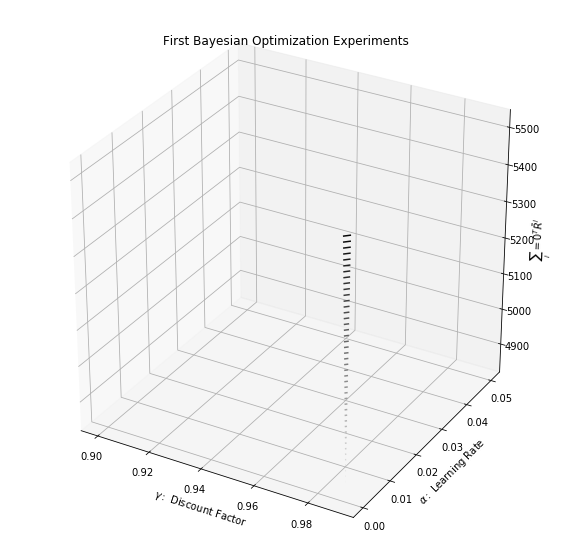

In [90]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.contour3D(f1_grid, f2_grid, mu_to_plot, 50, cmap='binary')
#ax.plot_surface(f1_grid, f2_grid, mu_to_plot,cmap='viridis',linewidth=0)
ax.set_xlabel(r'$\gamma:$ Discount Factor')
ax.set_ylabel(r'$\alpha:$ Learning Rate')
ax.set_zlabel(r'$\sum_i=0^T \bar{R}^i$');
plt.title("First Bayesian Optimization Experiments")

In [89]:
X_obs

,GAMMA,L_RATE
0,0.937532,0.036044
1,0.990000,0.000100
2,0.916993,0.004986
3,0.904710,0.025002
4,0.916997,0.004946
5,0.901192,0.037993
6,0.978386,0.024064
7,0.912069,0.037832
8,0.986021,0.041861
9,0.941079,0.048080


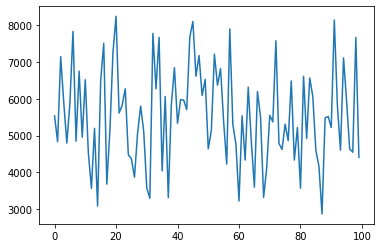

In [91]:
plt.plot(y_obs)